# Module 6: CFA
# Investment Use Case: Avoiding Biases in Investment models using Machine Learning 
# =========================================================

Many statistical, behavioural and structural biases can distort the high risk area of investment model development. Investment models are responsible for selecting or recommending individual names or securities for investments, and so the outcomes have a potentially very high impact on stake holders. Investment models are broadly separated into stock selection and portfolio construction models. Stock selection models, because of their granular focus, generally greater data needs and higher complexity, are typically most exposed to biases in model development. Whereas portfolio construction models - a challenging and complex area of research for sure - tends to be more generically based on diversifying return characteristics using, typically covariance or clustering based optimizations. This use case focues on mitigating biases in stock selection models.

Factor based models are used by the vast majority of quanitative investment managers, after Fama and French's seminal research in the early 1990s. Traditional factor approaches use sensitive, linear models that are affected by many biases, that can result in model outcomes not respresenting true causal relationships. This in turn delivers biased results. 

Machine learning gives quantitative managers that still use these approaches, the option to attempt to supe them up. However, the options for retro-fitting ML onto a traditional quant process is not as obvious as it seems, as we shall see.

This use case develops three stock selection models in a global equities universe. 
First, we examine the risk of biases of traditional quant models, based on a linear factor approach, identifying problematic assumptions and violations.
Second, we look to improve this traditional quant approach by bolting on a machine learning elements: traditional quant+ML. We will see that this presents additional risks and biases, as we attempt to improve a traditional quant model using a neural net.
Third, we examine a purpose designed ML approach, designed to avoid or address many of the possible biases in both traditiona quant and traditional quant+ML. 

### References
[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100
 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077
 
[2] Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

[3] Fabozzi, F. J., Focardi, S. M., & Kolm, P. N. (2010). Quantitative equity investing: Techniques and strategies. John Wiley & Sons.

[4] Israel, R., & Ross, A. (2017). Measuring factor exposures: Uses and abuses. The Journal of Alternative Investments, 20(1), 10-25.

[5] Levin A. (1995). Stock Selection via Nonlinear Multi-Factor Models. Advances in Neural Information Processing Systems, 8.
  https://proceedings.neurips.cc/paper/1995/file/d6ef5f7fa914c19931a55bb262ec879c-Paper.pdf 


### Code Repositories
https://github.com/danphilps/Investment-SAI






Get key packages, download data and get in good shape.

In [283]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# package for navigating the operating system
import os

If this is running in Google Colab.... we extract the GitHub loc where the data resides....

In [284]:
!git clone https://github.com/danphilps/Investment-SAI

fatal: destination path 'Investment-SAI' already exists and is not an empty directory.


In [285]:
# We should see a "Investment-SAI" directory....
os.listdir()

['dat.csv',
 'Emerging_5_Factors.csv',
 'Investment-SAI',
 'TB3MS.csv',
 'fama_french.zip',
 'a']

We will now mount the GoogleDrive where the data resides

In [286]:
from google.colab import drive
import os
drv = drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/your_project_folder/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [287]:
os.listdir('/content/gdrive/MyDrive')

['How to get started with Drive.pdf',
 'ESG Nomenclature',
 'Structured Data',
 'MSCI ACWI Bloomberg ESG Data (2020-11-19T15_51_34.092) (1).xlsx',
 'MSCI ACWI Bloomberg ESG Data (2020-11-23T12_56_42.825).xlsx',
 'MSCI ACWI Bloomberg ESG Data (2020-11-24T12_27_36.605).xlsx',
 'MSCI ACWI Bloomberg ESG Data (2020-11-25T11_41_31.839) (1).xlsx',
 'MSCI ACWI Bloomberg ESG Data (2020-11-30T18_16_29.244) (1).xlsx',
 'MSCI ACWI Bloomberg ESG Data (2020-12-04T14_24_15.938).xlsx',
 'SASB_feature_assignment - DP.xlsx',
 'SASB_feature_assignment - DP.gsheet',
 'MSCI ACWI Bloomberg ESG Data (2020-12-09T08_29_25.667).xlsx',
 'MSCI ACWI CIQ Environmental Data.csv',
 'MSCI_ACWI_GlassdoorCompanyRatings.csv',
 'gl_aggregated_materiality.csv',
 'gl_temp_master_ratios.csv',
 'gl_master_final.csv',
 'gl_master_final_X.csv',
 'gl_materiality_sector.csv',
 'gl_master_final_Y.csv',
 'SASB_feature_assignment_V4.gsheet',
 'WBS Lectures',
 'ACWI fundamental data.xlsx',
 'MSCI ACWI Identifiers plusURLS.xlsx',
 'MS

# Stage1: Business Case

The business case for investment models tends to be very clear, but it is surprising how few analysts spend time defining the "ground truth" for their models, other than the obvious objective of selecting "higher alpha" securities. "Ground truthing" in this context could be described as getting the decision right for the right reasons, which a positive alpha end point does not necessarily define. For instance a defensive strategy might benefit from a stock that ultimately generates positive alpha, but if the downside characteristics of that stock int eh shorter run are terrible, it could provde to be a bacd investment. In this case the groun truth might simply be, positive alpha AND defensive characteristics. Once the groiund truth has been defined,hypotheses are then needed which can be tested, and an experimental setup is required to test them.





# Stage2: Data

First we pull in the data we need, wrangle it, examine it and prepare it.


## Stage2a. Load Data
Step into the Investment-SAI/data directory and get the security level returns csv, load this into a DataFrame

In [288]:
# Change the working directory...
os.chdir('Investment-SAI/data')
# Extract security level returns
df_sec_rets = pd.read_csv('dat.csv')
# Extract 3m T-Bill rate
df_tb3ms = pd.read_csv('TB3MS.csv')

Extract factor returns from the Ken French data library

In [289]:
# Libraries...
import urllib.request
import zipfile
import csv

# Get factor returns from the Ken French data repository
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/Emerging_5_Factors_CSV.zip"
# Download the file and save it
# We will name it fama_french.zip file
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
# Next we extact the file data
# We will call it ff_factors.csv
zip_file.extractall()
# Make sure you close the file after extraction
zip_file.close()

# Extract into a dataframe
df_ff_factors = pd.read_csv('Emerging_5_Factors.csv', skiprows = 3)

# Data wrangling... remove invalid rows (annual factors)
# There is white space in the date columns... strip this out
df_ff_factors.iloc[:,0] = df_ff_factors.iloc[:,0].str.strip()

# Find the start of the invalid rows and remove them all...
for row in range(1,df_ff_factors.shape[0]):
  if df_ff_factors.iloc[row,0].isnumeric() == False:
    break
df_ff_factors = df_ff_factors.drop(df_ff_factors.index[row:])

print(df_ff_factors.head)

<bound method NDFrame.head of     Unnamed: 0      Mkt-RF       SMB       HML        RMW         CMA    RF
0       198907     0.60     -0.39      15.53     -99.99    -99.99      0.70
1       198908    1.63       8.78      -3.73     -99.99    -99.99      0.74
2       198909   14.41       3.32      -7.70     -99.99    -99.99      0.65
3       198910    -2.18     -0.49      -4.36     -99.99    -99.99      0.68
4       198911    0.72      0.43        2.22     -99.99    -99.99      0.69
..         ...         ...       ...       ...        ...         ...   ...
395     202206   -6.77       0.12     -0.99     -1.51        0.38      0.06
396     202207    0.24      0.78      1.47       0.09        1.19      0.08
397     202208    0.75      0.31       0.87     -2.36        0.40      0.19
398     202209  -10.76      0.17      3.84       0.22        4.40      0.19
399     202210   -1.99      0.83       3.59     -0.60        3.04      0.23

[400 rows x 7 columns]>


### Stage2b. Data Wrangling and Preprocessing

We want the data with dates as rows, securities as columns (and factors as columns in the factor data). 
The latest date should be the top row... dates should all be the same format in each file.


Factor data:

In [290]:
# Get FF factors sorted and transposed...
# Columns as dates (latest date in the left col), rows are factors or securities...
df_ff_factors = df_ff_factors.sort_values(by=df_ff_factors.columns[0], ascending=False)
# Set row index as dates
df_ff_factors.index = df_ff_factors.iloc[:,0].astype(int)
df_ff_factors = df_ff_factors.iloc[:,1:]
# Force type to float
df_ff_factors = df_ff_factors.astype(dtype=float)
# stated at percentages? No...
df_ff_factors = df_ff_factors/100

#Check...
df_ff_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Unnamed: 0,,,,,,
202210,-0.0199,0.0083,0.0359,-0.0060,0.0304,0.0023
202209,-0.1076,0.0017,0.0384,0.0022,0.0440,0.0019
202208,0.0075,0.0031,0.0087,-0.0236,0.0040,0.0019
202207,0.0024,0.0078,0.0147,0.0009,0.0119,0.0008
202206,-0.0677,0.0012,-0.0099,-0.0151,0.0038,0.0006


Risk free retuns data:

In [291]:
# Separate RF from the Factor DataFrame
df_tb3ms = df_ff_factors[['RF']]
df_ff_factors = df_ff_factors.drop(columns='RF')

#Check...
df_tb3ms.head()

,RF
Unnamed: 0,
202210,0.0023
202209,0.0019
202208,0.0019
202207,0.0008
202206,0.0006


Security level returns data:

In [292]:
# Get security returns sorted and transposed...
# separate the security static data into another DataFrame
df_sec_static = df_sec_rets[['TICKER','NAME','SECTOR','COUNTRY']].transpose()
# Remove static data from the returns data frame
df_sec_rets = df_sec_rets.drop(['NAME','SECTOR','COUNTRY'], axis=1)
# Transpose to dates rows, securities columns
df_sec_rets = df_sec_rets.transpose()
# Set columns as TICKER
df_sec_rets.columns = df_sec_rets.iloc[0,:]
df_sec_rets = df_sec_rets.iloc[1:,:]
# Row index, dates to integer values
df_sec_rets.index = df_sec_rets.index.astype(int)

df_sec_rets

TICKER,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1233.0,1234.0,1235.0,1236.0,1237.0,1238.0,1239.0,1240.0,1241.0,1242.0
202210,0.015466,NaN,NaN,NaN,NaN,NaN,NaN,0.088226,0.035268,0.080022,...,-0.081479,0.001897,NaN,NaN,0.017754,-0.038338,-0.025137,-0.063330,0.047736,-0.082764
202209,-0.078267,NaN,NaN,NaN,NaN,NaN,NaN,-0.256076,-0.107093,-0.070149,...,0.041886,-0.253796,NaN,NaN,-0.057480,-0.090533,-0.182098,-0.074483,-0.001601,-0.173638
202208,0.022625,NaN,NaN,NaN,NaN,NaN,NaN,0.018059,0.032409,0.176039,...,-0.145800,-0.048463,NaN,NaN,-0.012613,0.071217,-0.060197,0.214663,0.174986,-0.163977
202207,-0.046285,NaN,NaN,NaN,NaN,NaN,NaN,0.155629,0.156827,-0.060423,...,0.078485,-0.160098,NaN,NaN,0.045095,0.059226,-0.038707,0.077234,0.036502,0.184783
202206,-0.174248,NaN,NaN,NaN,NaN,NaN,NaN,-0.251703,0.004471,-0.117245,...,-0.164017,-0.081680,NaN,NaN,-0.209230,0.060308,0.093577,-0.075751,-0.261309,-0.162446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200306,-0.033725,0.022944,-0.041206,0.037502,-0.000805,-0.120038,-0.096703,0.017493,0.214309,0.106460,...,NaN,NaN,NaN,NaN,NaN,0.112575,NaN,0.214379,NaN,NaN
200305,0.018288,0.347534,0.058162,0.317328,0.034123,0.589883,0.144294,-0.057198,-0.029923,-0.002020,...,NaN,NaN,NaN,NaN,NaN,0.165515,NaN,0.281787,NaN,NaN
200304,0.232334,0.516898,0.754661,0.103423,0.125564,0.133804,0.255365,0.182462,-0.063037,0.339535,...,NaN,NaN,NaN,NaN,NaN,0.256816,NaN,0.115087,NaN,NaN
200303,0.033275,0.382077,0.551300,-0.079611,0.050399,36.099299,0.176971,0.032819,-0.106661,0.286560,...,NaN,NaN,NaN,NaN,NaN,-0.261565,NaN,-0.058430,NaN,NaN


Let's view our data... right orientation? no nan?

In [293]:
df_tb3ms.head()
df_ff_factors.head()
df_sec_rets.head()

TICKER,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,1233.0,1234.0,1235.0,1236.0,1237.0,1238.0,1239.0,1240.0,1241.0,1242.0
202210,0.015466,NaN,NaN,NaN,NaN,NaN,NaN,0.088226,0.035268,0.080022,...,-0.081479,0.001897,NaN,NaN,0.017754,-0.038338,-0.025137,-0.063330,0.047736,-0.082764
202209,-0.078267,NaN,NaN,NaN,NaN,NaN,NaN,-0.256076,-0.107093,-0.070149,...,0.041886,-0.253796,NaN,NaN,-0.057480,-0.090533,-0.182098,-0.074483,-0.001601,-0.173638
202208,0.022625,NaN,NaN,NaN,NaN,NaN,NaN,0.018059,0.032409,0.176039,...,-0.145800,-0.048463,NaN,NaN,-0.012613,0.071217,-0.060197,0.214663,0.174986,-0.163977
202207,-0.046285,NaN,NaN,NaN,NaN,NaN,NaN,0.155629,0.156827,-0.060423,...,0.078485,-0.160098,NaN,NaN,0.045095,0.059226,-0.038707,0.077234,0.036502,0.184783
202206,-0.174248,NaN,NaN,NaN,NaN,NaN,NaN,-0.251703,0.004471,-0.117245,...,-0.164017,-0.081680,NaN,NaN,-0.209230,0.060308,0.093577,-0.075751,-0.261309,-0.162446


#### Data Wrangling: Date alignment
Enforce the end and start dates and ensure date alignment across all data we are using... take the data with the earliest end date as the end date for all series... do the same for the start date too.

In [294]:
# Enforce the end date...
# Get the date_end that we will use, this will be the study end date...
date_end = min([max(df_tb3ms.index.astype(int)), max(df_ff_factors.index.astype(int)), max(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) > date_end])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) > date_end])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) > date_end])

# Enforce the start date...
# Get the date_start that we will use, this will be the study start date...
date_start = max([min(df_tb3ms.index.astype(int)), min(df_ff_factors.index.astype(int)), min(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) < date_start])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) < date_start])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) < date_start])

Sanity check you data for errors and (silly) mistakes. Eye ball the distributions and correlations too. Here are some of the checks you can do.

1. Date alignment errors
2. Check all percentages are formatted correctly
3. Check nan values have a low count

#### Governance: Validation check on our data
Validating the input data to ensure it is in the right shape, the dates are correctly aligned, formats and conventions are clear (eg whether percentages are staged as decimals (10.0) or percentages (0.10)? And ensuring here are no obvious holes in the data we will use. 

There are many more checks we can add here, including loading independent data sources to spot check stock level data, placing sensible bounds on variables based on our expereiences (eg the USD risk free rate should not be below 0%, or about 15% in the history we are using). As obvious as these checks may be to you now, picking up such errors in the depths of the data process driving a production model would not be obvious at all.

In [295]:
# Sanity checking
# 1: Dates are aligned?
if  (df_tb3ms.index.equals(df_ff_factors.index) == False) | (df_ff_factors.index.equals(df_sec_rets.index) == False):
  raise TypeError('Sanity: Dates are not aligned...')

# 2: Percentages are percentages (not decimals)? 
# Check df_tb3ms median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_ff_factors.iloc[:,:].abs().median(skipna=True).median(skipna=True)
sd = df_ff_factors.iloc[:,:].std(skipna=True).median(skipna=True)
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  

# Check df_ff_factors median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_tb3ms.iloc[0,:].abs().median(skipna=True) # only one row... only one median call needed
sd = df_tb3ms.iloc[0,:].std(skipna=True) # only one row... no median call needed
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  

# Check df_sec_rets median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_sec_rets.abs().median(skipna=True).median(skipna=True)
# median of each row, median across rows
sd = df_sec_rets.std(skipna=True).median(skipna=True) # std of each row, median across rows
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  

# 3: Many nan? 
if df_tb3ms[df_tb3ms==np.nan].count().sum() / (df_tb3ms.shape[0]*df_tb3ms.shape[1]) > 0.33:
  raise TypeError('Sanity: df_tb3ms; > 33% of values are nan')  
if df_ff_factors[df_ff_factors==np.nan].count().sum() / (df_ff_factors.shape[0]*df_ff_factors.shape[1]) > 0.33:
  raise TypeError('Sanity: df_ff_factors; > 33% of values are nan')  
if df_sec_rets[df_sec_rets==np.nan].count().sum() / (df_sec_rets.shape[0]*df_sec_rets.shape[1]) > 0.33:
  raise TypeError('Sanity: df_sec_rets; > 33% of values are nan')  


## Stage2c. Exploratory data analysis (EDA)

For investment models EDA should encompass data types (interval, cardinal, nominal), distributions, correlations, and more. It is a good idea to examine pairwise distributions of input variables to ensure colinearities (and other relationships) do not exist.  

#### Bias Alert: Linear Regression Violations

The four most common violations of classical regression theory that occur in cross-sectional factor models are: 

1. multicollinearity*: correrlation in input variables
2. the errors in variables problem**: where incorrectly measured variables or proxy variables are used
3. common variation in residuals** such as heteroskedasticity
4. endogeneity***: where the returns from the stock we are modelling affect the input variables. This might be caused by too many investors using similar models.

*: Multicolinearity is best dealt with by removing collinear variables from the regression
**: There are statistical techniques that address 2, and 3.
***: Endogenous bias is extremely difficult to detect and deal with. We will come onto this.


In [296]:
# Functions for EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Function we will call to add R2 and p-val to the off-diagonal cells of the pair plot
def R2func(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    _, _, r, p, _ = stats.linregress(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Function we will call to add normality test stat and p-val to diagnonal cells of pair plot
# Note that inputs to linear regression are not required to be normally distributed.
def normalityfunc(x, hue=None, ax=None, **kws):
    """Plot the Shapiro Wilk p-value in the top left hand corner of diagonal cells."""
    stat, p = shapiro(x)
    ax = ax or plt.gca()
    ax.annotate(f'Shapiro-Wilk stat = {stat:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


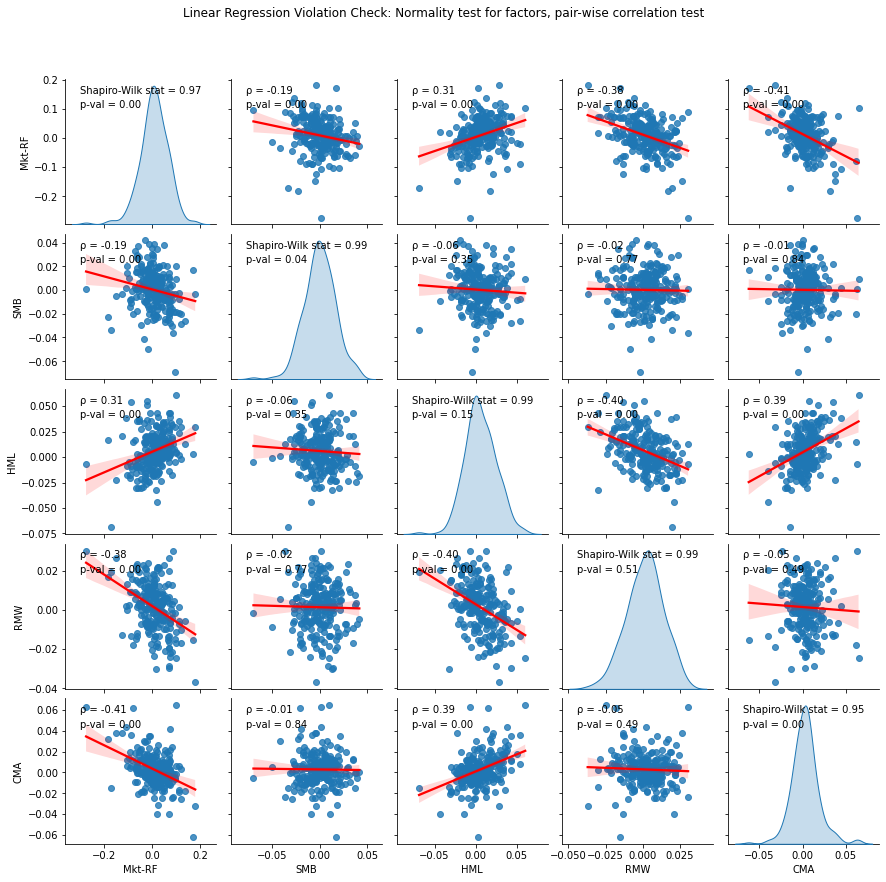

In [297]:
# Run EDA Functions on our dataset

# Generate pairplot
pp = sns.pairplot(df_ff_factors, kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

# Run the R2func for all off diagnonal cells, and normalityfunc for the diagonal ones...
pp.map_lower(R2func)
pp.map_upper(R2func)
pp.map_diag(normalityfunc)

# Title...
pp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

pp.fig.suptitle('Linear Regression Violation Check: Normality test for factors, pair-wise correlation test')

plt.show()


# Stage3: Model Design

## 3a. Traditional Quantitative approach: Linear Factors

We first examine a traditional quantitative approach noting the biases involved in the construction of a traditional stock selection model, the basis of quantitative equity investment approaches for the vast majority of quant managers.
We will use a fundamental factor model, also known as a cross-sectional factor model, after Fama and French. These models use linear regression to fit common factors (value (HML), small cap (SMB), etc) to stock returns, by learning coefficients (betas or factor loadings) for each factor. This has the familar form:
$$
R_{it} = α_{i} + \sum\limits_{j=1}^{K} \beta_{ij} f_{ij} + ϵ_{ij} \qquad \text{where}\; i=1,\dots, N\; j=1,\dots, K
$$
Where $R_{it}$ is the return of stock $i$ at time $t$, $\beta$ is the exposure (loading) of stock $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 

We will first learn the loadings of each stock to each of the factors in the dataset, and we will then use these loadings and the factor returns to determine the expected return of each stock to form model portfolios.     


We now specify our model training process, using OLS regression, with the option of robust standard errors. We will wrap this up as a function, so as we can call it multiple times over the study term, to generate trades for each month.

Note that we sanity check parameters, to provide basic checks, and we analyse the residuals produced by the model to ensure residuals are normally distributed (using a SHapiro-Wilk test in this case, with the option of generating a scatter plot in the function too).
Let us run the function, using our 5 factor regression on the first security in the dataset, column=0.

Many refinements can be made to this simple model.

In [298]:
# Packages to use...
import statsmodels
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Function that will run our OLS model to determine factor loadings, for a given security, 
# over a given period
# Note the two optional parameter... 
#   use_robust_cm: estimate from a robust covariance matrix
#   plot_residual_scatter: which will generate a scatter plot of our residuals (y vs y_hat)
def factormodel_train_single_security(sec_col_no: int,
                     df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int,
                     use_robust_cm: bool = False,
                     plot_residual_scatter: bool = False) -> (object, np.array, np.array, float, float):
  
  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  

  # Get X and y data...
  # NB: Security returns... deduct Rf
  y = [df_sec_rets.iloc[t, sec_col_no] - df_tb3ms.iloc[t, 0] for t in range(date_end,date_start)]
  X = df_ff_factors.iloc[date_end:date_start, :]
  
  # Instantiate and train OLS model
  X = sm.add_constant(X) #<< statsmodels requires we manually add an intercept.
  ols_model = OLS(y, X)
  ols_model = ols_model.fit()

  # Optional ... Use heteroskedasticity-autocorrelation robust covariance?
  if use_robust_cm:
      ols_model = ols_model.get_robustcov_results()

  # Predict in sample
  y_hat = ols_model.predict(X)
  resid = y-y_hat

  # In sample prediction: Examine residuals for normality... 
  # NB: The null hypothesis (H0) states that the variable is normally distributed, 
  # and the alternative hypothesis (H1) states that the variable is NOT normally distributed.  
  sw_stat, sw_p = shapiro(resid)
  
  # Optional ...
  if plot_residual_scatter == True:   
    # square plot     
    fig, ax = plt.subplots()
    ax.scatter(y-y_hat, y_hat)        
    ax.set_aspect(aspect=1)
    plt.title('Residual Plot: Shapiro-Wilk p-val: ' + str(round(sw_p, 2)))
    plt.show()

  return (ols_model, y, y_hat, sw_stat, sw_p)

Next, we forecast expected returns for each security using our factor models trained above. Again, we wrap this as a function so as we can call it multiple times in a simulation.

In [299]:
# Forecast the expected return of a single stock
def factormodel_forecast_er(df_stock_factor_loadings: pd.DataFrame,
                            df_ff_factors: pd.DataFrame,
                            r_f: float, 
                            date_start: int,
                            date_end: int) -> np.array:

  #date_start = 35
  #date_end = 0
  #r_f = 0.01
  #df_stock_factor_loadings=pd.DataFrame(ols_model.params)

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.shape[1] != df_stock_factor_loadings.shape[0]-1: #Include the intercept dimension
    raise TypeError("Must pass same number of factors for security as the df_ff_factors")  

  # Factor returns to assume
  factor_excess_returns = df_ff_factors.iloc[date_end:date_start, :].sort_index()
  factor_excess_returns = np.array(1+factor_excess_returns.iloc[date_end:date_start, :]).prod(axis=0)
  factor_excess_returns = factor_excess_returns ** (12/(date_start-date_end))-1

  # Stock Forecast E(R)_i,t+h
  e_r = np.dot(factor_excess_returns.T, df_stock_factor_loadings.iloc[1:, :])

  #Only add constant and r_f to (non zero returns) populated securities
  non_zero_secs = e_r != 0
  e_r[non_zero_secs] = e_r[non_zero_secs] + r_f +  df_stock_factor_loadings.loc['const', non_zero_secs]
  
  return e_r


#### Bias Alert: Complexity Bias (Training Window Size)
Part of model validation in timeseries domains is to run historic simulations, and to avoid data snooping bias, we need to use a small subset of the data we have. A relatively long history of returns is required to learn a linear regrssion model with many input variables[1], less for a classification model. If we use a ML model, which generally have more parameters, we need even more data for training. In short, we may not have high enough frequency data to train a stable model. This problem is exaccerbated when running simulations, as to avoid data snooping bias we must only use a subset of our full dataset that preceeds each simulation date.   

The more samples we have, and the more accurate the data, the more accurate our model will be. The more data we have the more features and model parameters  (ie complexity) we can employ to approximate our target function. However, there is a balanmcing act between complexity and the data available, and if our model becomes too complex for the amount of data we will likely overfit to the data, and our model will not perform well out of sample. It will be a bad predictor.

For linear factor models, the analogue is that these models assume: 
$$N >> K$$
[2] , a serious limitation requiring explicit dimensionality reduction, in a world with expanding data resources .


So how much data do we need for our chosen model? And what is the maximum number of features we should use?


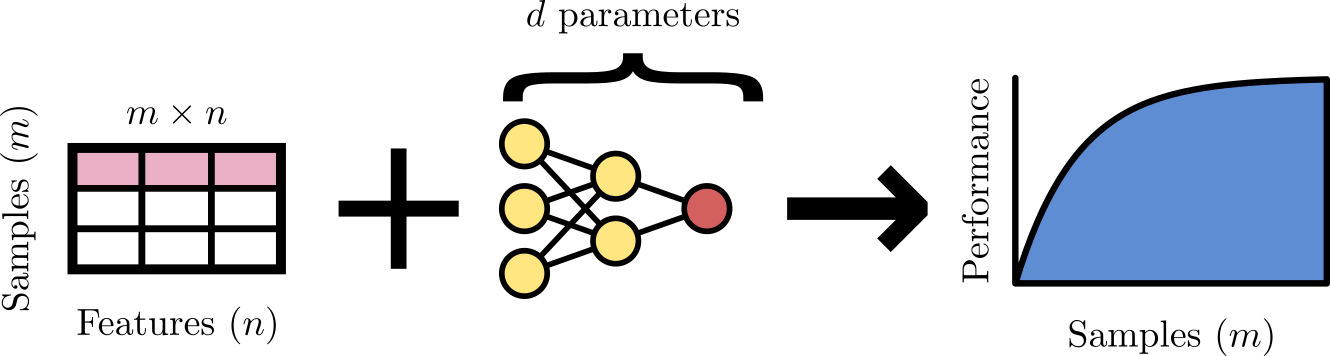


### Model complexity1: Instances vs features and classes used
A rule of thumb for the number of instances, N, needed to train a stable model with K input features, for a classification model with C categories to classify:

N ≥ 10 K · C,

instances. For a regression model:

N ≥ 50 K,

instances are suggested.


### Model complexity2: Instances vs parameters
A rule of thumb for the limit on number of parameters, ¦θ¦, our model should have, given the size of our training data [3], we suggest this: 

¦θ¦ ≤ N/10 


[1] Robert C. Merton, “On Estimating the Expected Return on the Market: An Exploratory Investigation,” Journal of Financial Economics, 8 (1980), pp. 323–361.

[2] Valliappa Lakshmanan, Sara Robinson, and Michael Munn. Machine learning design patterns. O’Reilly Media, 2020

[3] Kevin P. Murphy, Probabilistic machine learning: an introduction. MIT press, 2022

In [300]:
#***********************************************************************
#*** Complexity bias Sanity Check!***
#***********************************************************************  
def bias_complexity_check_regression(no_of_instances: int,
                          no_of_features: int = 0,
                          no_of_parameters: int = 0) -> (bool, int, int):

  failed = False
  cb_K = no_of_features
  cb_n = no_of_instances
  
  # 1. Feature complexity: n ≥ 50 K
  if cb_n > 50 * cb_K:
    failed = True
  
  feature_max = int(round(cb_n / 50, 0))

  # 2. Parameter complexity: ¦θ¦ ≤ n/10
  #
  # The number of model parameters (ie weights) should observe the constraint
  # wrt training instances, n, features, K:
  #
  # |theta| >= n/10  
  param_max = int(round(cb_n / 10, 0))
  
  if no_of_parameters > param_max:
    failed = True

  return (failed, feature_max, param_max)


### Vectorized Simple Factor model

The function we wrote above, "factor_model_single_security", is a simplified approach, calculating betas for one stock at a time. The matrix form of the traditional factor model is:

$$
R_{t} = \mathbf{α +β f_{t} + ϵ_{t}}
$$

We show the vectorized code to implement this version of the same function below, which can calculate many stock level betas at a time for a huge speed up. The matrix form of the factor equation above is 



In [301]:
# Function that will run a vectorized OLS model, for a given security, over a given period
# Vectorized OLS regression is far faster. 
# Note the two optional parameter... 
#   use_robust_cm: estimate from a robust covariance matrix
#   plot_residual_scatter: which will generate a scatter plot of our residuals (y vs y_hat)
def factormodel_train_manysecurities(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_start: int,
                     date_end: int) -> (object, np.array, np.array):

  # sanity
  if date_start < date_end: 
    raise TypeError("Latest date is date=0, date_start is > date_end")
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  

  # Get X and y data...
  # NB: Security returns from date_end to date_start... deduct Rf
  y = np.array([df_sec_rets.iloc[t, :] - df_tb3ms.iloc[t, 0] for t in range(date_end,date_start)])
  X = np.array(df_ff_factors.iloc[date_end:date_start, :]).astype('float')

  # Prepare matrices for linalg, and OLS
  intercept = np.ones((date_start-date_end,1))
  X = np.concatenate((intercept, X), axis=1)

  # Flag nan containing security returns
  cols_non_nan = ~np.isnan(y).any(axis=0)
  y_train = y[:,cols_non_nan]

  # Sanity Check: Biases ************************
  if bias_complexity_check_regression(no_of_instances=X.shape[0],
                                      no_of_features=X.shape[1],
                                      no_of_parameters=X.shape[1]) == True:
    raise TypeError("Complexity bias checks failed")  
  # Sanity Check: Biases ************************

  # Train model
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)  

  # Predict in sample
  y_hat = np.dot(X, ols_betas)
  resid = y_train - y_hat

  # We removed nan rows... Rebuild to a full vector
  ols_betas_final = pd.DataFrame(np.zeros((ols_betas.shape[0], y.shape[1])))
  ols_betas_final.loc[:, cols_non_nan] = ols_betas

  ols_betas_final.columns = df_sec_rets.columns
  ols_betas_final.index = ['const'] + df_ff_factors.columns.to_list()
  return (ols_betas_final, y, y_hat)


Let us call our functions to train a factor model for the first security in the dataset(factormodel_train_single_security) using the full term of the data available, and then calculate this security's expected returns (factormodel_forecast_ER). We will also opt to generate a residual plot (by setting factormodel_train_single_security parameters to plot_residual_scatter=True).
Our function will also print the summary stats for the regression.
Finally we will set a sanity check for normality of the redisuals. If the Shapiro-Wilk test produces a p-val of >10\% we can accept the null hypothesis, implying that the distribution of residuals is normal. 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


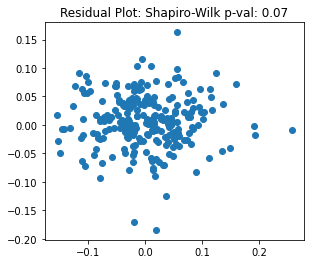

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     22.81
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           1.39e-18
Time:                        13:30:58   Log-Likelihood:                 306.26
No. Observations:                 237   AIC:                            -600.5
Df Residuals:                     231   BIC:                            -579.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0049      0.005     -1.026      0.3

In [302]:

# Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
ols_model, y, y_hat, sw_t, sw_p = factormodel_train_single_security(sec_col_no=0, 
                                             df_tb3ms=df_tb3ms, 
                                             df_sec_rets=df_sec_rets, 
                                             df_ff_factors=df_ff_factors, 
                                             date_start=df_ff_factors.shape[0], 
                                             date_end=0, 
                                             plot_residual_scatter=True)
# Examine the fit, coefficients and OLS analytics.
print(ols_model.summary())

# Forecast E(R) for this security.
df_stock_er = factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_model.params), 
                                df_ff_factors=df_ff_factors, 
                                r_f=df_tb3ms.iloc[0,0],
                                date_start=df_ff_factors.shape[0], 
                                date_end=0,)

print("Expected Return Forecast for Stocks")
print(df_stock_er)

# Check for normality in the residuals
if sw_p < 0.10:
  print("Residuals appear to be non-normal!") # Make an error in live code 

In [303]:
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def factormodel_forecast_all_er(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                    window_size: int = 50,
                    factor_return_history: int = 36) -> pd.DataFrame:

  # E(R) for each stock, in each time period
  df_stock_er = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_stock_er.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_stock_er.columns = df_sec_rets.columns[0:df_sec_rets.shape[1]].astype(int)
  #
  df_stock_SW_pval = df_stock_er.copy(deep=True)

  #Step through time... earliest to latest.
  for i in range(df_ff_factors.shape[0]-window_size-1, -1, -1):
    # Run our function, returning only the result object
    ols_coefs, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets, 
                                              df_ff_factors=df_ff_factors, 
                                              date_start=i+window_size, #<< Note we pass in the start date here
                                              date_end=i)  #<< Note we pass in the end date here
    
    # Generate E(R) from our stock level factor model...      
    # Factor return assumption      
    e_r = factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_coefs), 
                                    df_ff_factors=df_ff_factors,
                                    r_f=df_tb3ms.iloc[i, 0],
                                    date_start=i+factor_return_history,
                                    date_end=i) 
    df_stock_er.iloc[i,:] = e_r

  return df_stock_er

# Run the function with our data
df_all_er = factormodel_forecast_all_er(df_tb3ms=df_tb3ms, 
                   df_sec_rets=df_sec_rets,
                   df_ff_factors=df_ff_factors,
                   window_size=50)

df_all_er

<ipython-input-301-cc1707e74da6>:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)


TICKER,1,2,3,4,5,6,7,8,9,10,...,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242
202210,0.116431,0.0,0.0,0.0,0.0,0.0,0.0,0.123667,0.023915,0.040824,...,0.026088,-0.106260,0.0,0.0,0.059325,-0.012883,-0.189386,0.054277,0.245286,-0.048265
202209,0.101102,0.0,0.0,0.0,0.0,0.0,0.0,0.100025,0.026267,0.040245,...,0.031507,-0.086626,0.0,0.0,0.058869,0.000515,-0.164726,0.062650,0.216377,-0.032398
202208,0.109712,0.0,0.0,0.0,0.0,0.0,0.0,0.159097,0.059295,0.084305,...,0.031169,-0.035910,0.0,0.0,0.081632,0.028578,-0.089881,0.094287,0.234195,0.024167
202207,0.106007,0.0,0.0,0.0,0.0,0.0,0.0,0.140172,0.067141,0.097744,...,0.033240,-0.022409,0.0,0.0,0.090656,0.035711,-0.092273,0.095040,0.204115,0.006383
202206,0.098975,0.0,0.0,0.0,0.0,0.0,0.0,0.121281,0.064038,0.098424,...,0.028767,-0.008240,0.0,0.0,0.082719,0.028090,-0.080636,0.085691,0.186000,-0.002772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200707,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200706,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200705,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Factor Model Applied Over Time
We now use our functions to conduct a historic simulation, stepping forward over time points in our dataset, and using a 36month sliding window to train the model for each security, at each timestep. We start in the earlies time period and end at the most recent period, generating a expected returns for each stock as we go.
At the end of this process we will be able to say which stocks we favor, and which we do not in each time period, based on the expected return our models will have predicted.


## Simple Simulation Functions
Having run the Factor model we have forecast expected return for each security in each time step in the test period. We now need to convert these predictions into portfolio positions, to run a historic simulation.This will allow us to test how effective our stock selection is based on the forecasts of expected return.

In each period we select the top quantile (defaulting to 25th percentile) of our stock forecasts, and generate a DataFrame of equal weighted stocks that reside in this quantile.
Next we assume a certain rebalance frequency, and simualte the past returns of this portfolio. 

In [304]:
# Establish trades for 6monthly rebalances: Return a full DF of trade weights (per column/security)
# For every time slice, set the highest quantile as equal weighted trades
# Quantiles have nan entries and zero entries removed
def trades_topquantile_generate(df_all_er: pd.DataFrame,
                            rebalance_freq: int,
                            min_quantile_to_buy: float = 0.75) -> pd.DataFrame:

  # Sanity
  if df_all_er.index[1] < df_all_er.index[2]:
    raise TypeError("Sort order of dates is wrong. Latest date should be at the top.")
  if (rebalance_freq < 0 == True) | (rebalance_freq > 60 == True):
    raise TypeError("rebalance_freq < 0 | rebalance_freq > 60.")
  if (min_quantile_to_buy < 0 == True) | (min_quantile_to_buy > 1 == True):
    raise TypeError("min_quantile_to_buy < 0 | min_quantile_to_buy > 1")

  # Initialise df_trades
  df_trades = pd.DataFrame(np.zeros((df_all_er.shape[0],df_all_er.shape[1])), columns=df_all_er.columns, index=df_all_er.index)  
  insert_zero_row = False # Error? or zero values? We insert a zero row...
  date_start_non_zero = -1 # WHat is the first non-zero row 

  # Loop through time... start to end.
  # Progress bar
  for t in range(df_all_er.shape[0]-1,0,-rebalance_freq): 
    
    # Get this period's stocks (cols), get valid stocks only
    df_opset_curr = pd.DataFrame(df_all_er.iloc[t, :]).T
    valid_secs = (df_opset_curr.iloc[0, :].isna() | df_opset_curr.iloc[0, :] != 0).to_numpy()

    # Get our 
    qu = df_opset_curr[df_opset_curr.columns[valid_secs]].quantile(q=min_quantile_to_buy, axis=1).iloc[0]
    no = df_opset_curr[df_opset_curr[df_opset_curr.columns[valid_secs]] > qu].count(axis=1).iloc[0]
    
    #Create trades row    
    df_trades_curr = pd.DataFrame(df_all_er.iloc[t, :]).T
    df_trades_curr.iloc[:,:] = float(0)
    if no != 0:
      # Add equal weighted trades...
      trade_secs = ((df_opset_curr.iloc[0, :] > qu) & (df_opset_curr.iloc[0, :] != 0))
      df_trades_curr[df_trades_curr.columns[trade_secs]] =  1/no      
      
      #Record the first non-zero row
      if date_start_non_zero == -1: 
          date_start_non_zero = i

      insert_zero_row = False
    else:
      insert_zero_row = True

    # Insert zero row...
    if insert_zero_row == True: 
      df_trades_curr = pd.DataFrame(df_all_er.iloc[t, :]).T
      df_trades_curr.iloc[:,:] = float(0.0)

    # Overwrite date/time row in df_trades
    df_trades = df_trades.drop(axis=0, index=df_trades_curr.index)
    df_trades = df_trades.append(df_trades_curr)

    # Progress
    print('Processing date: ' + str(df_trades.index[-1]))

  # Correct the sort order...
  df_trades = df_trades.sort_index(ascending=False)

  #Sanity... Trades in each period totals a max of 100%? if non-zero.
  if ((df_trades.sum(axis=1).max() > 1.001 == True) | (df_trades.sum(axis=1).max() < 99.999 == True)):
    raise TypeError("Sanity checks on returns failed")

  return df_trades

# Run the function to establish simple positio sizes based
df_trades = trades_topquantile_generate(df_all_er=df_all_er, rebalance_freq=6, min_quantile_to_buy=0.4)

Processing date: 200704
Processing date: 200710
Processing date: 200804
Processing date: 200810
Processing date: 200904
Processing date: 200910
Processing date: 201004
Processing date: 201010
Processing date: 201104
Processing date: 201110
Processing date: 201204
Processing date: 201210
Processing date: 201304
Processing date: 201310
Processing date: 201404
Processing date: 201410
Processing date: 201504
Processing date: 201510
Processing date: 201604
Processing date: 201610
Processing date: 201704
Processing date: 201710
Processing date: 201804
Processing date: 201810
Processing date: 201904
Processing date: 201910
Processing date: 202004
Processing date: 202010
Processing date: 202104
Processing date: 202110
Processing date: 202204


We can review the trades created. Trades should be an equal size in each period, and should be created in those securities where the value is greater than the quantile specified (top 25% by default) 

Take the trades we have just generated and run a historic simulation.

A historic simulation. A simple simulation function 

Period: 60, CAGR:0.0
Period: 59, CAGR:0.0
Period: 58, CAGR:0.0
Period: 57, CAGR:0.0
Period: 56, CAGR:0.0
Period: 55, CAGR:0.0
Period: 54, CAGR:0.0
Period: 53, CAGR:0.0
Period: 52, CAGR:0.0
Period: 51, CAGR:0.0
Period: 50, CAGR:0.0
Period: 49, CAGR:0.0
Period: 48, CAGR:0.0
Period: 47, CAGR:0.0
Period: 46, CAGR:0.0
Period: 45, CAGR:0.0
Period: 44, CAGR:0.0
Period: 43, CAGR:0.0
Period: 42, CAGR:0.0
Period: 41, CAGR:0.0
Period: 40, CAGR:0.0
Period: 39, CAGR:0.0
Period: 38, CAGR:0.0
Period: 37, CAGR:0.0
Period: 36, CAGR:0.0
Period: 35, CAGR:0.0
Period: 34, CAGR:0.0
Period: 33, CAGR:0.0
Period: 32, CAGR:0.0
Period: 31, CAGR:0.0
Period: 30, CAGR:1.0
Period: 29, CAGR:1.0012355001871103
Period: 28, CAGR:1.0962226091139007
Period: 27, CAGR:1.1679886328634037
Period: 26, CAGR:1.2128043066617318
Period: 25, CAGR:1.1940622742395148
Period: 24, CAGR:1.1965436521354333
Period: 23, CAGR:1.3266343280935677
Period: 22, CAGR:1.4529996816500108
Period: 21, CAGR:1.5399533448432057
Period: 20, CAGR:1.857230

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


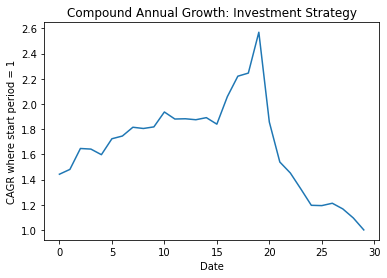

In [305]:
import matplotlib.pyplot as plt
import math

# Simulation routine
def run_sim(df_trades: pd.DataFrame,
            df_sec_rets: pd.DataFrame, 
            rebalance_freq: int = 6,
            transaction_costs: float = 0.001,
            show_analytics: bool = True,
            date_start_of_sim: int = -1) -> pd.DataFrame:
  # Sanity
  # Period1 must have a 100% allocation...
  if ((df_trades.sum(axis=1).max() > 1.001 == True) | (df_trades.sum(axis=1).max() < 99.999 == True)):
    raise TypeError("Trades pass in do not all sum to 100%")
  if df_trades.index[0] < df_trades.index[-1]:
    raise TypeError("df_trades needs to have the latest date at the top")
  if date_start_of_sim > df_trades.shape[0]-2:
    raise TypeError("date_start_of_sim > df_trades.shape[0]-2")
  
  if date_start_of_sim == -1:
    date_start_of_sim = df_trades.shape[0]-2
  
  # Ini CAGR of each security as the initial trade
  df_sec_cagr = pd.DataFrame(np.zeros((date_start_of_sim+2, df_trades.shape[1])), columns=df_trades.columns, index=df_trades.index[0:date_start_of_sim+2])
  cagr_total = -1
  period_no = -1

  # Step through time: rebalance_freq
  for t in range(date_start_of_sim, -1, -1):
    
    # Trades in period?
    if (df_trades.iloc[t,:].sum() != 0):
      # Start positions
      #===============================================
      if cagr_total == -1:
        df_sec_cagr.iloc[t,:] = df_trades.iloc[t,:]
        cagr_total = df_sec_cagr.iloc[t,:].sum(skipna=True)
        period_no = 0

        #Sanity
        if (round(cagr_total, 2) != 1):
          raise TypeError("Initial trades do not equal 100% Row: " + str(i) + ', total:' + str(round(cagr_total,2)))       

      else:
        # Establish any buy trades in the period...
        #================================================
        trade_buy_flag = ((df_trades.iloc[t,:] != np.nan) & (df_trades.iloc[t,:] > 0)).to_list()
        trade_buy_cols = df_trades[df_trades.columns[trade_buy_flag]]    
        tot_buy_trades = df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:].sum(skipna=True) 

        # Sanity: All trades are assumed to be rebalances of 100% of the portfolio
        if round(tot_buy_trades,2) != 1:
          raise TypeError('Trades must equal 100% not:')  

        # Positions roll forwards...
        #================================================
        df_sec_cagr.iloc[t,:] = df_sec_cagr.iloc[t+1,:] * (1+df_sec_rets.iloc[t,:])
        cagr_total = df_sec_cagr.iloc[t,:].sum()

        # Execute Sell/Buys instantaneously at the close.
        # (We overwrite the CAGR of the buy trades with the new trade* cagr_total,
        # and we zero out the sell trades, having already added their contribution to the cagr_total)
        #================================================      
        # Remove all positions
        df_sec_cagr.loc[t, :] = 0
        # Establish the new positions
        df_sec_cagr[df_sec_cagr.columns[trade_buy_flag]].iloc[t,:] = df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:] * cagr_total
        #Transaction costs
        trans_costs_current = abs(df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:] - df_sec_cagr[df_sec_cagr.columns[trade_buy_flag]].iloc[t,:]/cagr_total)
        df_sec_cagr[df_sec_cagr.columns[trade_buy_flag]].iloc[t,:] += df_trades[df_trades.columns[trade_buy_flag]].iloc[t,:] * -abs(trans_costs_current)

        period_no += 1
    else:
      # No trades... Positions roll forwards...
      #================================================      
      #Sanity
      if df_sec_rets.iloc[t,:].abs().sum(skipna=True) == 0:
        raise TypeError("Returns are zero in period: " + str(i))       
      df_sec_cagr.iloc[t,:] = df_sec_cagr.iloc[t+1,:] * (1+df_sec_rets.iloc[t,:])
      
      period_no += 1
    print('Period: ' + str(t) + ', CAGR:' + str(df_sec_cagr.iloc[t,:].sum()))
  
  # Sort into date order
  df_sec_cagr = df_sec_cagr.sort_index(ascending=False)

  #Analytics:
  if show_analytics == True:
    # Analytics
    sim_ana = pd.DataFrame(np.zeros((5,2)))
    sim_ana.iloc[0,0] = 'Total Return (TR)(annualized)'
    sim_ana.iloc[0,1] = df_sec_cagr.iloc[0,:].sum(skipna=True) ** (12/period_no) -1
    sim_ana.iloc[1,0] = 'Standard deviation (SD) (annualized)'
    sim_ana.iloc[1,1] = df_sec_cagr.iloc[0:period_no, :].sum(skipna=True).std(skipna=True) * math.sqrt(12)
    sim_ana.iloc[2,0] = 'Sharpe Ratio (TR/SD)'
    sim_ana.iloc[2,1] = sim_ana.iloc[0,1] / sim_ana.iloc[1,1]
    print(sim_ana)  

    #CAGR chart
    plt.close    
    plt.plot([t for t in range(0, period_no)], df_sec_cagr.iloc[0:period_no, :].sum(axis=1, skipna=True))
    plt.title('Compound Annual Growth: Investment Strategy')
    plt.xlabel('Date')
    plt.ylabel('CAGR where start period = 1')
    plt.show()    

  return df_sec_cagr

# Run the simulation function
df_sec_cagr = run_sim(df_trades=df_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, date_start_of_sim=60)  


In [306]:
df_trades.sum(axis=0)

TICKER
1       0.002088
2       0.000000
3       0.000000
4       0.000000
5       0.000000
          ...   
1238    0.004162
1239    0.008320
1240    0.010408
1241    0.006246
1242    0.002083
Length: 1242, dtype: float64

#### Bias Alert: Certainty bias

Any opinion offered about the probability, likelihood, certainty, or similar property for a hypothesis cannot be derived from statistical methods alone. In particular, significance tests and confidence intervals do not by themselves provide a logically sound basis for concluding an effect is present or absent with certainty or a given probability. This point should be borne in mind whenever one sees a conclu
sion framed as a statement of probability, likelihood, or certainty about a hypothesis. Information about the hypothesis beyond that contained in the analyzed data and in conventional statistical models (which give only data probabilities) must be used to reach such a conclusion; that information should be explicitly acknowledged and described by those offering the conclusion. Bayesian statistics offers methods that attempt to incorporate the needed information directly into the statistical model; they have not, however, achieved the popularity of P values and confidence intervals, in part because of philosophical objections and in part because no conventions have become established for their use.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877414/

#### Bias Alert: Endogenous bias
Endogeneity bias is not a simple violation and there is no easy statistical solution. It has serious consequences for outcomes, where in the presence of endogenous variables OLS learns biased and inconsistent parameters. P-values can be seriously misleading. All it takes is one endogenous variable to seriously distort ALL OLS parameters.
https://artnet.unescap.org/tid/artnet/mtg/gravity09_tues3.pdf

One potentially concerning endogeneity is self-fulfilling prophecy of factor investing, where stocks with high correlations to commonly used factors would cause investments in those stocks, causing price appreciation, affirming that the correlations with those factors caused the price rises.


## 2a. Factor Approach with Non-linear Regression

We now examine using machine learning tools, applied to a traditional quantative framework.
Traditional linear factor approaches, after Fama and French, assume persistent long-run returns of factors, and that a stock's loadings to these factors can be (linearly) mutliplied into factor returns to find their expected return. This is likely to be a flawed assumption as stock returns do not move in straight lines with respect to factor returns. Instead of keeping this assumption, we can add a nonlinear element to the relationship between our stocks' factor loadings and returns. We can train a ML model, in this case a neural net, to find a nonlinear function to fit all of our $N$ stocks' $K$ loadings, $\beta_ij$, to all their returns, $R_{it}$:

$$
R_{it} =\overset{̃}{f}_{j=1}(β_{i1}, β_{i2}, …, β_{iK}, f_{i1}, f_{i2}, …, f_{iK})
$$

Where $R_{i}$ is the return of stock $i$ at time $t$, $\beta$ is the exposure (loading) of stock $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 


To approximate the function $\overset{̃}{f}()$ is substantially more complex than simply assuming a linear relationship as factor models dosince it requires both the determination of this complex function.
While we may be shedding an oversimplistic assumption linear models make, we are now open to all sorts of biases in constructing our approach.

We will use an MLP neural net. To avoid ovefitting of neural net, ML is typically separated into a train and test data. Additionally, we are taking on much more complexity with this nonlinear features, with many hyperparameters needing to be specified, such as the size of the hidden layer, activation functions to choose, learning rate, and so on. The following neural net has been heuristically tuned, ie by trial and error, and this process took about 30minutes to complete. If you try changing the settings in the MLPRegressor's fit function yourself, you will see how variable the predictions are from this model. There is huge sensitivity to the typs of normalization use, the activation function used and so on. All this implies a lack of stability. Our message: avoid complex models to avoid biases. 



The MLP we will use has the following architecture, where the 11 input units relate to our 6, stock level factor coefficients (ie 5 $β$s, one $α$), and 5 corresponding factor returns over the longer run $f$. The architecture is shown with on hidden-layer, of 5 hidden units, and one output $R$.

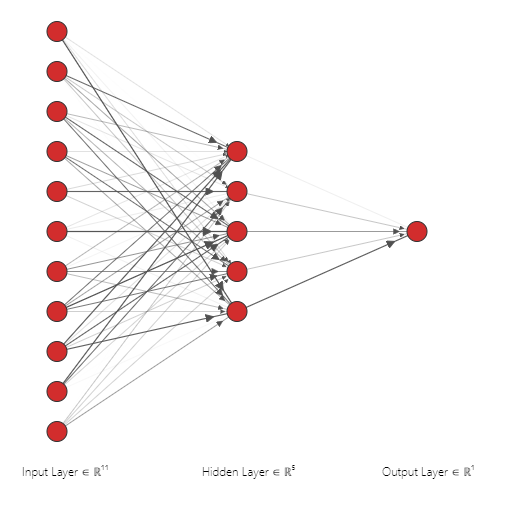

#### Bias Alert: Normalization Data Snooping bias

For neural nets we almost always need to normalize (or standardize) the input data. There is room for a weak form of data snooping bias though, in historic simulations. 
We can either normlize by row (ie across a given stock's datapoints), so that each column is in proportion to the row. Or we can normlize by column. 

For stock selection applications row level normalization makes less sense, because taking PE ratio as an example, you want to compare one stock's PE ratio versus the PE ratio of all others; ie column normalize. It makes little sense to row normalize, where a stock's PE is scaled against the same stock's EBITDA/EV.  
The bias arises when we column normalize (or standardize) training data to train our model, and then pass in new data for forecasting, which may contain different min and maxes in each column. In this case all the column scalings will slightly change if the min max range changes from the training data.
In this case we can either live with the inaccuracy, or save the min-max training range and normalize the new data to the training range, capping the min/max at the training min/max, or allowing the min/max to exceed the -1/+1 range typically used for min/max scaling.


#### Bias Alert: Repeated testing (multiplicity) bias

Complex machine learning approaches generally have many hyperparameters, such as neural nets, with the number of hidden nodes, the learning rate, optimizer used, activation function and so on. It is standard practices to conduct a grid search of these hyper parameters, known as hyperparameter tuning, until we find the optimum comdination. This is a problem if we are hypothesis testing the results of our model, for instance sampling the R2, and F-stat of the goodness of fit of our prediction, because the p-val is calculated to assume the probability of one test being conducted. This is known as multiplicity bias.   

Applying many tests in a single study results in an increased probability of detecting a significant finding just by chance (the problem of multiplicity). It then discusses some of the methods that have been proposed for correcting for multiplicity, including single-step procedures (e.g., Bonferroni); multistep procedures, such as those of Holm, Hochberg, and Šidák; false discovery rate control; and resampling approaches. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3015194/

#### 2a. i) Utility Functions: Calculate stock returns, Prep data for training/pedicting

In this section we declare the function to calculate stock returns we will need as the $y$ variable for our neural net function: stock_rets_get.
We also need a function to generate the 11 inputs to the neural net: nonlinfactor_er_func_prep_data

In [307]:

# Calculate security returns on the same term as the factor loadings.
 # This will be the input for our ML model.
 # for securities with zero values in their history, remove them
def stock_rets_get(df_tb3ms: pd.DataFrame,
                    df_sec_rets: pd.DataFrame,
                    date_start: int,
                    date_end: int,
                    window_size: int = 36, 
                    remove_intercept_coef: bool = True) -> pd.DataFrame:
  '''
  Args:
      df_tb3ms: DataFrame containing time series of 3m risk free rate
      ols_betas_final: DataFrame containing factor loadings for all securities
      date_start: training time window start period
      date_end: training time window end period
      window_size: Factor lodings calculated over what period?    
      remove_intercept_coef: Remove intercept for each security?  
      
  Returns:
      dic_factor_loadings: dictionary indexed by t, containing 

  '''

  # sanity
  if df_sec_rets.shape[0] < date_start + window_size: 
    raise TypeError("df_sec_rets.shape[0] < date_start + window_size")
  if df_sec_rets.shape[0] < date_start: 
    raise TypeError("df_sec_rets.shape[0] < date_start")
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 

  # NB: elements of the dict = time periods. The element numbers corrspond 
  # with row numbers in all other DatFrames in this note book (eg t=1, it t=1 in all other structures)
  df_all_stock_returns = pd.DataFrame(np.zeros((date_start-date_end, df_sec_rets.shape[1])))
  df_all_stock_returns.index = df_sec_rets.index[date_end:date_start]

  z = 0
  for i in range(date_start, date_end, -1):
    # Calc stock returns, annualized
    sec_returns = df_sec_rets.iloc[i:i+window_size, :].sort_index(ascending=True)
    
    #Ignore any entries with zeros
    sec_returns = sec_returns.replace(to_replace=0, value=np.nan)
    ignore_cols = ~df_sec_rets.isna().max(axis=0)
    
    sec_returns = 1 + sec_returns.loc[:,ignore_cols]   
    sec_returns = sec_returns.loc[:,ignore_cols].prod(axis=0)
    
    # Assume monthly data, annualize
    if (window_size > 12):
      sec_returns.loc[ignore_cols] = sec_returns.loc[ignore_cols] ** (12/(window_size)) - 1  
    else:
      sec_returns.loc[ignore_cols] = sec_returns.loc[ignore_cols] - 1
    
    # All stock returns...
    df_all_stock_returns.iloc[z, ignore_cols.T] = sec_returns.T
    z += 1  
  
  return df_all_stock_returns

# Run function and get all factors loadings for all time periods
df_stock_returns = stock_rets_get(df_tb3ms=df_tb3ms,
                                        df_sec_rets=df_sec_rets,
                                        date_start = 1,
                                        date_end = 0,
                                        window_size=36)





In [308]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


## PRepare data for training, testing and predicting from the nn
def nonlinfactor_er_func_prep_data(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_end: int,
                     window_size: int = 36,
                     func_training_period: int = 1) -> (pd.DataFrame, pd.DataFrame):

  '''
  Args:
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      date_end: training time window end period
      window_size: return window to use when calculating stock and factor returns.
      func_training_period: pass 1 for predictions, >=1 for training. How many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end
      
  Returns:
      X: X data used to train/test/predict
      y: X data used to train/test/predict
  '''

  # sanity
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 
  if (func_training_period < 0) | (func_training_period > df_sec_rets.shape[0]):
    raise TypeError("(func_training_period < 0) | (func_training_period > df_sec_rets.shape[0]") 
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 

  # Built training data over thei many periods: func_training_period
  # The time points to load are limited by the dtaa we have. Build X and y for window_size, func_training_period, else the longest period available...
  X = pd.DataFrame()
  y = pd.DataFrame()
  for t in range(date_end, min(df_sec_rets.shape[0]+func_training_period,
                              date_end+func_training_period, 
                              df_sec_rets.shape[0]+window_size,), 1):

    #================================
    # Get data components for X at time t: df_stock_factor_loadings, factor_excess_returns; 
    # and y: stock_returns
    #================================
    # X data...
    stock_factor_loadings, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                                  df_sec_rets=df_sec_rets, 
                                                  df_ff_factors=df_ff_factors, 
                                                  date_start=t+window_size, #<< Note we pass in the start date here
                                                  date_end=t)  #<< Note we pass in the end date here

    # X data... Factor returns to assume
    factor_excess_returns = df_ff_factors.iloc[t:t+window_size, :].sort_index()
    factor_excess_returns = np.array(1+factor_excess_returns).prod(axis=0)
    factor_excess_returns.astype(float)
    # Annualize
    if(window_size > 12):
      factor_excess_returns = factor_excess_returns ** (12/(window_size))-1

    # Deduct rf from stock level returns, as it will have been for factor returns
    rf_ret = df_tb3ms.iloc[t:t+window_size, :].sort_index()
    rf_ret.astype(float)

    # y data... Stock level returns
    stock_returns = df_sec_rets.iloc[t:t+window_size, :].sort_index()
    stock_returns.astype(float)
    
    # Adjust returns for r_fs
    for j in range(0, stock_returns.shape[1]-1):      
      stock_returns.iloc[:,j] = stock_returns.iloc[:,j] - rf_ret.iloc[:,0]  # subtract r_f from each monthly return
    stock_returns = np.array(1+stock_returns).prod(axis=0)
    # Annualize
    if(window_size > 12):
      stock_returns = stock_returns ** (12/(window_size))-1

    # Prep X and y  at time for training nn 
    #================================
    # X...
    # Dimension X
    X_t = pd.DataFrame(np.zeros((stock_factor_loadings.shape[0]+df_ff_factors.shape[1], stock_factor_loadings.shape[1])))
    X_t.columns = [str(int(col)) + '_' + str(t) for col in df_sec_rets.columns]

    # Add stock loadings to X
    X_t.iloc[0:stock_factor_loadings.shape[0],:] = stock_factor_loadings.copy(deep=True) #dict is indexed off 1, DFs and arrays off 0
    X_t.astype(float)
    X_index = stock_factor_loadings.index + '_coef'

    # Add factor returns to X (duplicate for each stock)
    for j in range(0, stock_factor_loadings.shape[1]):
      X_t.iloc[stock_factor_loadings.shape[0]:, j] = factor_excess_returns
    X_index = X_index.append(df_ff_factors.columns + '_ret')
    X_t.index = X_index

    # y... 
    y_t = pd.DataFrame(stock_returns.copy()).T #dict is indexed off 1, DFs and arrays off 0
    y_t.columns = [str(int(col)) + '_' + str(t) for col in df_sec_rets.columns]
    y_t.index = ['ALL']
   
    # Refine X and y
    X_t = X_t.replace(to_replace=0, value=np.nan)
    y_t = y_t.replace(to_replace=0, value=np.nan)

    X_invalid_cols_to_drop = X_t.columns[X_t.isna().sum()>0]
    y_invalid_cols_to_drop = y_t.columns[y_t.isna().sum()>0]
    invalid_cols_to_drop = X_invalid_cols_to_drop.append(y_invalid_cols_to_drop)
    invalid_cols_to_drop = invalid_cols_to_drop.unique()

    X_t = X_t.drop(labels=invalid_cols_to_drop, axis=1)
    y_t = y_t.drop(labels=invalid_cols_to_drop, axis=1)


    # Add X and y at time t to the master X, y
    X = pd.concat((X, X_t), axis=1) 
    y = pd.concat([y, y_t], join = 'outer', axis = 1)

    return X.T, y.T


# train nn 
nlf_X, nlf_y = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              window_size=36,
                                              func_training_period=60)




<ipython-input-301-cc1707e74da6>:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)


#### 2a. ii) Train, and Forecast Functions

Now we need functions to train our neural net, and to provide the final forecast of stock returns in a given time period. 
We will need these function to generate expected returns which will feed into our trade generating function, decaled earlier, and our simulation function, declared earlier.

<ipython-input-301-cc1707e74da6>:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)


[-8.26594588e-01 -1.24721910e+00  1.88077760e+00  7.17326839e-01
  1.22171095e-01 -3.28089994e-02 -7.87724997e-01 -6.01971731e-01
 -2.64314726e-01  1.94009578e-01 -1.11223207e+00 -8.92293455e-02
 -4.06405459e-01 -2.17068679e-01 -6.52190161e-01 -1.05822349e+00
 -7.64714126e-01 -2.20538071e-01  5.17112718e-01 -4.25252664e-01
  7.94713773e-01 -8.63215279e-01 -5.78341714e-01 -7.86435686e-01
 -9.77703854e-02 -7.04271418e-01  1.78758273e-01 -2.54401411e-02
 -3.30818002e-01  8.97136744e-01 -6.03526393e-01 -5.77076843e-01
  6.37482655e-01 -7.23314405e-01  1.68088696e-03 -1.05000883e-01
 -4.64148160e-01 -3.98202980e-01 -2.73520821e-01  3.78891693e-02
 -4.97177285e-01 -1.52641779e-01  1.03715531e+00 -3.38729870e-03
 -3.43875177e-01 -5.03819209e-01 -1.08823584e+00 -1.04434030e+00
 -1.30003884e+00 -3.84938090e-01 -1.75876194e+00 -6.07957736e-01
 -5.26515514e-01 -8.97134629e-01  2.29431540e-01  6.78387236e-01
 -1.27449041e+00 -3.27648427e-01 -1.76570942e-01 -6.68017354e-01
 -4.61159551e-01 -8.42244

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


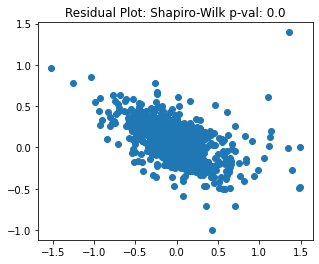

In [309]:
# Train er function
def nonlinfactor_train_er_func(df_tb3ms: pd.DataFrame,
                     df_sec_rets: pd.DataFrame,
                     df_ff_factors: pd.DataFrame,
                     date_end: int,
                     window_size: int = 36,
                     func_training_period: int = 60,
                     hidden_layer_sizes: list = [5],
                     plot_residual_scatter: bool = False) -> (object, np.array, np.array, float, float):
  '''
  Args:
      df_tb3ms: risk free rate
      df_sec_rets: stock level returns monthly
      df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
      date_end: training time window end period
      window_size: return window to use when calculating stock and factor returns.
      func_training_period: how many periods to use to train the nn? func_training_period=1 will use only one cross section, t=date_end
      hidden_layer_sizes: neural net number of units in hidden layer.
      plot_residual_scatter: generate a graph of the residulas for the model
      
  Returns:
      nn_mod: trained sklearn MLP model object
      X: X data used to train
      y: y data used to train
      y_hat: insample y_hat
      sw_stat, sw_p: residual normality tests.

  '''

  # Prep data for training the nn  
  #==================================='
  X, y = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=date_end,
                                              window_size=window_size,
                                              func_training_period=func_training_period)
 
  # train nn
  #================================
  hidden_layer_sizes = [5]
  plot_residual_scatter = True

  # Normalize X data... and transpose...
  X_norm = StandardScaler().fit_transform(X)  


  print(X_norm[:,0])
  print(X.iloc[:,0])

  # Spilt into train and test data
  #X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.3, random_state=None)
  X_train_norm = X_norm
  y_train = y

  # Train ANN... R = f(loadings;factor returns)
  nn_mod = MLPRegressor(hidden_layer_sizes=(hidden_layer_sizes),
                          max_iter=500, 
                          learning_rate_init=0.01, 
                          random_state=0, 
                          solver='lbfgs', #'lbfgs', 
                          tol=0.001,  
                          activation='logistic') #'tanh', 'logistic')

  nn_mod = nn_mod.fit(X=X_train_norm, y=y_train) 

  # Predict in sample
  y_hat = nn_mod.predict(X)
  resid = y_train.values-y_hat

  # In sample prediction: Examine residuals for normality... 
  # NB: The null hypothesis (H0) states that the variable is normally distributed, 
  # and the alternative hypothesis (H1) states that the variable is NOT normally distributed.  
  sw_stat, sw_p = shapiro(resid)
  
  # Optional ...
  if plot_residual_scatter == True:   
    # square plot     
    fig, ax = plt.subplots()
    ax.scatter(y_train.iloc[:,0]-y_hat, y_hat)        
    ax.set_aspect(aspect=1)
    plt.title('Residual Plot: Shapiro-Wilk p-val: ' + str(round(sw_p, 2)))
    plt.show()

  return nn_mod, X, y, y_train, y_hat #, sw_stat, sw_p 

# train nn 
nn_model, nlf_X, nlf_y, nlf_y_train, nlf_y_hat = nonlinfactor_train_er_func(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              window_size=36,
                                              func_training_period=12)

In [310]:
# Forecast the expected return of a single stock
def nonlinfactor_forecast_er(nn_model: object,                             
                            df_tb3ms: pd.DataFrame,
                            df_sec_rets: pd.DataFrame,
                            df_ff_factors: pd.DataFrame,
                            date_end: int,
                            window_size: int = 36) -> pd.DataFrame:

   
  # sanity
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 
  if df_ff_factors.shape[0] < df_ff_factors.shape[1]:
    raise TypeError("Must pass factor returns as columns not rows")  
  if df_ff_factors.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned")  
  if df_tb3ms.index[0] != df_sec_rets.index[0]:
    raise TypeError("Dates misaligned") 
  if (window_size < 0) | (window_size > df_sec_rets.shape[0]):
    raise TypeError("(window_size < 0) | (window_size > df_sec_rets.shape[0]") 
  
  # Factor returns to assume, annualized...
  factor_excess_returns = df_ff_factors.iloc[date_end:date_start, :].sort_index()
  factor_excess_returns = np.array(1+factor_excess_returns.iloc[date_end:date_start, :]).prod(axis=0)

  # Annulize monthly returns
  if ((window_size) > 12):
    factor_excess_returns = factor_excess_returns ** (12/((window_size)))-1
  else:
    factor_excess_returns = factor_excess_returns-1

    
  # Prep data for training the nn  
  # Only use the latets period: func_training_period=1
  #==================================='  
  X_test, y_test = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=date_end,
                                              window_size=window_size,
                                              func_training_period=1)
  X_test_index = X_test.index.to_list()

  #*Quirk ... Sklearn needs 2D array to predict - insert zero row...
  blank_row = np.repeat([999999], X_test.shape[1])
  X_test = np.vstack((X_test, blank_row))

  # Stock Forecast E(R)_i,t+h
  e_r = nn_model.predict(X_test)

  # r_f...
  e_r[(e_r!=0)] = e_r[(e_r!=0)] + df_tb3ms.iloc[0,date_end]

  # *Remove the added instance (99999) above...
  e_r = pd.DataFrame(e_r)
  e_r = e_r.iloc[0:-1,:]  
  e_r.index = X_test_index

  return e_r, X_test

# Run 
nlf_er, nlf_X_test = nonlinfactor_forecast_er(nn_model=nn_model, 
                                                      df_tb3ms=df_tb3ms, 
                                                      df_sec_rets=df_sec_rets,
                                                      df_ff_factors=df_ff_factors,
                                                      date_end=0,
                                                      window_size=36)


nlf_er

<ipython-input-301-cc1707e74da6>:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)


,0
1_0,0.290513
8_0,0.409239
9_0,-0.016732
10_0,-0.011456
12_0,0.253793
...,...
1238_0,-0.021731
1239_0,-0.359598
1240_0,0.049475
1241_0,0.557801


In [311]:
# Loop through time, from the earliest period, to the latest, calculating E(R) for every stock we have data for in each time period
# We will generate a DataFrame containing the expected returns for each stock in each period as we go.
def nonlinfactor_forecast_all_er(df_tb3ms: pd.DataFrame,
                      df_sec_rets: pd.DataFrame,
                      df_ff_factors: pd.DataFrame,
                      window_size: int = 50) -> (pd.DataFrame, object):

  # E(R) for each stock, in each time period
  df_all_er = pd.DataFrame(np.zeros((df_sec_rets.shape[0]-window_size, df_sec_rets.shape[1])))
  df_all_er.index = df_sec_rets.index[0:df_sec_rets.shape[0]-window_size]
  df_all_er.columns = df_sec_rets.columns[0:df_sec_rets.shape[1]].astype(int)
  #
  df_stock_SW_pval = df_all_er.copy(deep=True)

  #Step through time... earliest to latest.
  for t in range(df_ff_factors.shape[0]-window_size-1, -1, -1):
    # Run our function, returning only the result object
    df_stock_factor_loadings, _, _ = factormodel_train_manysecurities(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets, 
                                              df_ff_factors=df_ff_factors, 
                                              date_start=t+window_size, #<< Note we pass in the start date here
                                              date_end=t)  #<< Note we pass in the end date here
    
    
    # Get function of security returns = f(loadings and factor returns)
    nn_mod = nonlinfactor_train_er_func(df_tb3ms = df_tb3ms,
                                    df_sec_rets = df_sec_rets,
                                    df_ff_factors = df_ff_factors,
                                    date_end = t,
                                    window_size = window_size,
                                    func_training_period = 60,
                                    hidden_layer_sizes = [5],
                                    plot_residual_scatter = False)
    
    
    # Generate E(R) from our stock level factor model...      
    e_r = nonlinfactor_forecast_er(nn_model = nn_mod,
                            df_tb3ms=df_tb3ms,
                            df_sec_rets=df_sec_rets,
                            df_ff_factors=df_ff_factors,
                            date_end=t)
    df_all_er.iloc[t,:] = e_r

  return df_all_er 

# Run the function with our data
df_nlf_all_er, nn_mod_latest = factormodel_forecast_all_er(df_tb3ms=df_tb3ms, 
                   df_sec_rets=df_sec_rets,
                   df_ff_factors=df_ff_factors,
                   window_size=50)



<ipython-input-301-cc1707e74da6>:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)


In [312]:
# Run the function with our data
df_all_er = factormodel_forecast_all_er(df_tb3ms=df_tb3ms, 
                   df_sec_rets=df_sec_rets,
                   df_ff_factors=df_ff_factors,
                   window_size=36)

df_all_er

<ipython-input-301-cc1707e74da6>:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ols_betas, resid, rank, sigma = np.linalg.lstsq(X,y_train)


TICKER,1,2,3,4,5,6,7,8,9,10,...,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242
202210,0.108736,0.0,0.0,0.0,0.0,0.0,0.0,0.148759,0.017204,0.014331,...,0.061829,-0.091251,0.0,0.0,0.043722,-0.026316,-0.199519,0.065913,0.245445,-0.040743
202209,0.106555,0.0,0.0,0.0,0.0,0.0,0.0,0.125363,0.044377,0.017337,...,0.066004,-0.090886,0.0,0.0,0.040283,-0.010332,-0.162950,0.069318,0.223062,-0.031262
202208,0.114277,0.0,0.0,0.0,0.0,0.0,0.0,0.183659,0.078769,0.061915,...,0.053946,-0.032086,0.0,0.0,0.068182,0.014630,-0.088419,0.096904,0.233778,0.021726
202207,0.105948,0.0,0.0,0.0,0.0,0.0,0.0,0.151687,0.068231,0.077250,...,0.048675,-0.009018,0.0,0.0,0.078977,0.020960,-0.086622,0.087306,0.209989,0.013836
202206,0.099625,0.0,0.0,0.0,0.0,0.0,0.0,0.123866,0.070531,0.079743,...,0.041326,0.006916,0.0,0.0,0.073687,0.018600,-0.072552,0.077135,0.179819,-0.002403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200604,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
200603,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Finally we run our stock selection and simulation functions, applied to the non-linear factor approach...

Processing date: 200704
Processing date: 200710
Processing date: 200804
Processing date: 200810
Processing date: 200904
Processing date: 200910
Processing date: 201004
Processing date: 201010
Processing date: 201104
Processing date: 201110
Processing date: 201204
Processing date: 201210
Processing date: 201304
Processing date: 201310
Processing date: 201404
Processing date: 201410
Processing date: 201504
Processing date: 201510
Processing date: 201604
Processing date: 201610
Processing date: 201704
Processing date: 201710
Processing date: 201804
Processing date: 201810
Processing date: 201904
Processing date: 201910
Processing date: 202004
Processing date: 202010
Processing date: 202104
Processing date: 202110
Processing date: 202204
Period: 32, CAGR:0.0
Period: 31, CAGR:0.0
Period: 30, CAGR:0.9999999999999999
Period: 29, CAGR:1.0017558619937887
Period: 28, CAGR:1.1391988049331307
Period: 27, CAGR:1.1891188882475623
Period: 26, CAGR:1.2515218409990014
Period: 25, CAGR:1.200843924837073

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Period: 4, CAGR:1.5748180704286256
Period: 3, CAGR:1.6247193808800127
Period: 2, CAGR:1.602994088868262
Period: 1, CAGR:1.4352638048521267
Period: 0, CAGR:1.401199302303147
                                      0         1
0         Total Return (TR)(annualized)  0.144458
1  Standard deviation (SD) (annualized)  1.635751
2                  Sharpe Ratio (TR/SD)  0.088313
3                                   0.0  0.000000
4                                   0.0  0.000000


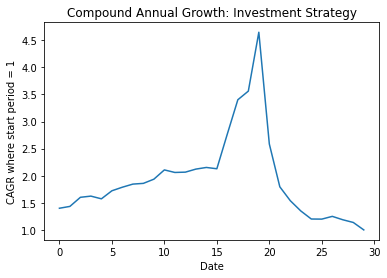

In [314]:

# Run the function to establish simple positio sizes based
df_nlf_trades = trades_topquantile_generate(df_all_er=df_nlf_all_er, rebalance_freq=6, min_quantile_to_buy=0.8)

# Run the simulation function
df_non_lin_sec_cagr = run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, date_start_of_sim=32)  

While simple factor models can be examined quite easily, we now have a more complex ML model in our approach; an MLP. We can examine this using SHAP


In [ ]:
# We need to install shap..
pip install shap

In [318]:
import shap

# Get data to use, to explain the MLP
X_test, y_test = nonlinfactor_er_func_prep_data(df_tb3ms=df_tb3ms,
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=date_end,
                                              window_size=36,
                                              func_training_period=1)

# SHAP XAI:
explainer = shap.Explainer(nn_mod_latest)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test.values, feature_names=y_test.columns)


ModuleNotFoundError: ignored

### Bias Alert: Complexity Bias
Using neural net is way too complex.
Limited number of features... limited number of data point.
Number of model paramters/data points  =


## 3b. Interpretable Machine Learning Approach


Now, rather than using a ML retrofit to traditional quantitative investing approach, we will use a purpose designed machine learning approach which is interpretable, and associative (a weaker take on causality, avoiding frequentist approaches that might just identify correlation not causation). This is a form of symbollic artificial intelligence (SAI), where the symbols are actually investment-rules. This ML approach will automatically find associations between our input features and our ground truth.






#### Mitigating Biases: Rules based ML
Rules based ML can avoid many of the biases in parametric investment models. 
Rules are non parametric (although rule learning may be). They assume no distribution, so there can be no violations of parametric assumptions as a result. Rules are also interpretable. Any stake holder should be able to review investment rules and gain some understanding of the way a model is operating, so long as the input functions remain qualitatively meaningful (eg earnings metrics, factor exposures and so on, rather than latent variables). Rules are also most easily considered as a classification problem, true or false. As a classification problem (rather than a regresion problem) , fewer data points and more features are able to be used under our complexity rules of thumb.
Certain rule learning approaches can be applied to a high number of features, avioding the need for explicit dimensionality reduction, which in the case of approaches such as PCA, can introduce more inductive biases and assumptions.


In [317]:
pip install investsai -q

     |████████████████████████████████| 1.3 MB 29.3 MB/s 


# Stage4: Model Deployment

As we have alrteady seen with the Credit Use Case, model deployment requires 

Investment model deployment requires a rigorous change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of this stage is monitoring of data drift, and the monitoring of stakeholder KPIs which are principally for investors, and compliance needs.
For investors, the characteristics of the strategy that were marketed and agreed with the investor, should be monitored and reported regularly with sufficient executive oversight and repotring to support it.
For Compliance, regular checking that the investment elements of the strategy are fully compliant with the investment management agreement (IMA), which organisations will tend to have in place as a separate system in any case. 


# Stage 5: Model Monitoring and Reporting